In [1]:
import os
from dotenv import load_dotenv
load_dotenv()


True

In [2]:

os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")


In [3]:
os.environ["LANGCHAIN_PROJECT"]="course_langgraph"
# # 
# llm = ChatGroq(groq_api_key=groq_api_key, model_name="llama3-8b-8192")
from langchain_ollama import OllamaLLM
llm=OllamaLLM(model="qwen2.5:0.5b")

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [5]:
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

In [6]:
Arxiv_APIWrapper= ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=250)
Wikipedia_APIWrapper= WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=250)
arxiv_tool= ArxivQueryRun(api_wrapper=Arxiv_APIWrapper)
wikipedia_tool= WikipediaQueryRun(api_wrapper=Wikipedia_APIWrapper)

In [7]:
tools=[arxiv_tool,wikipedia_tool]

In [8]:
class State(TypedDict):
    """State for the graph."""
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)   

In [10]:
llm = llm.bind(tools=tools)

In [11]:
def chatbot(state: State) :
    return{"messages":llm.invoke(state["messages"])}

In [12]:
graph_builder.add_node(
    "chatbot",chatbot)

In [14]:
from langgraph.prebuilt import ToolNode,tools_condition

In [13]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)


In [15]:
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [16]:
graph_builder.add_conditional_edges(
    "chatbot",tools_condition)
graph_builder.add_edge("tools", "chatbot")


In [17]:
graph= graph_builder.compile()


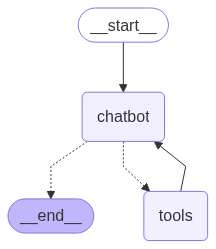

In [18]:
from IPython.display import display, Image
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception :    
    pass

In [20]:
user_input = "What is the latest research on quantum computing?"
events=graph.stream(    {"messages": [{"role": "user", "content": user_input}]},
    stream_mode="values")
for event in events:
    if event["messages"]:
        event["messages"][-1].pretty_print()
    else:
        print("No messages yet.")

================================ Human Message =================================

What is the latest research on quantum computing?


TypeError: Client.generate() got an unexpected keyword argument 'tools'